In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
class SlippageDataProcessor:
    """Handle all data loading and preparation"""
    
    def __init__(self, base_path='.'):
        self.base_path = Path(base_path)
    
    def load_single_day(self, ticker, date_pattern):
        """Load single day data for analysis"""
        ticker_path = self.base_path / ticker
        csv_files = list(ticker_path.glob(f"{ticker}_{date_pattern}*.csv"))
        
        if not csv_files:
            return None
            
        file = csv_files[0]
        
        try:
            df = pd.read_csv(file)
            
            # Handle duplicate ts_event columns
            if list(df.columns).count('ts_event') > 1:
                cols = list(df.columns)
                first_ts_event = cols.index('ts_event')
                df = df.iloc[:, [i for i, col in enumerate(cols) if col != 'ts_event' or i == first_ts_event]]
            
            # Parse timestamps
            df['ts_event'] = pd.to_datetime(df['ts_event'], format='mixed', utc=True)
            return df
            
        except Exception:
            return None
    
    def calculate_order_book_metrics(self, df):
        """Calculate core order book metrics"""
        # Basic price metrics
        df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
        df['spread'] = df['ask_px_00'] - df['bid_px_00']
        df['spread_bps'] = np.where(df['mid_price'] > 0, 
                                   (df['spread'] / df['mid_price']) * 10000, 
                                   np.nan)
        
        # Depth metrics
        bid_cols = [f'bid_sz_{i:02d}' for i in range(10) if f'bid_sz_{i:02d}' in df.columns]
        ask_cols = [f'ask_sz_{i:02d}' for i in range(10) if f'ask_sz_{i:02d}' in df.columns]
        
        df['total_bid_depth'] = df[bid_cols].sum(axis=1)
        df['total_ask_depth'] = df[ask_cols].sum(axis=1)
        df['total_depth'] = df['total_bid_depth'] + df['total_ask_depth']
        
        # Order book imbalance
        df['imbalance'] = np.where(df['total_depth'] > 0,
                                  (df['total_bid_depth'] - df['total_ask_depth']) / df['total_depth'],
                                  0)
        
        return df
    
    def get_market_snapshots(self, df, target_times_et=None):
        """Get order book snapshots at different market times"""
        
        if target_times_et is None:
            target_times_et = ["09:30", "10:30", "12:00", "14:00", "15:30"]
        
        # Map ET times to UTC (during daylight saving time)
        time_mapping = {
            "09:30": "13:30", "10:30": "14:30", "12:00": "16:00",
            "14:00": "18:00", "15:30": "19:30"
        }
        
        snapshots = {}
        
        for et_time in target_times_et:
            if et_time not in time_mapping:
                continue
                
            utc_time = time_mapping[et_time]
            target_hour, target_minute = map(int, utc_time.split(':'))
            target_total_minutes = target_hour * 60 + target_minute
            
            # Find closest timestamp
            df['utc_total_minutes'] = df['ts_event'].dt.hour * 60 + df['ts_event'].dt.minute
            time_diffs = abs(df['utc_total_minutes'] - target_total_minutes)
            min_diff = time_diffs.min()
            
            if min_diff > 30:  # More than 30 minutes away
                continue
            
            best_idx = time_diffs.idxmin()
            snapshot = df.loc[best_idx]
            snapshots[et_time] = snapshot
        
        return snapshots
    
    def calculate_slippage_function(self, snapshot, max_shares=3000):
        """Calculate buy-side slippage function from order book snapshot"""
        
        # Get ask-side order book levels (where buyers execute)
        ask_price_cols = [f'ask_px_{i:02d}' for i in range(10)]
        ask_size_cols = [f'ask_sz_{i:02d}' for i in range(10)]
        
        mid_price = snapshot['mid_price']
        
        # Build order book levels
        levels = []
        for i in range(10):
            if ask_price_cols[i] in snapshot.index and ask_size_cols[i] in snapshot.index:
                price = snapshot[ask_price_cols[i]]
                size = snapshot[ask_size_cols[i]]
                
                if pd.notna(price) and pd.notna(size) and size > 0:
                    levels.append({'price': price, 'size': int(size)})
        
        if not levels:
            return None
        
        total_liquidity = sum(level['size'] for level in levels)
        max_shares = min(total_liquidity, max_shares)
        
        # Calculate slippage for each trade size
        trade_sizes = []
        slippages_dollars = []
        
        for trade_size in range(1, max_shares + 1):
            shares_remaining = trade_size
            total_cost = 0
            shares_filled = 0
            
            # Walk through order book levels
            for level in levels:
                if shares_remaining <= 0:
                    break
                    
                shares_from_level = min(shares_remaining, level['size'])
                total_cost += shares_from_level * level['price']
                shares_filled += shares_from_level
                shares_remaining -= shares_from_level
            
            # If we couldn't fill the entire order
            if shares_remaining > 0:
                break
                
            # Calculate slippage
            avg_execution_price = total_cost / shares_filled
            slippage_dollars = avg_execution_price - mid_price
            
            trade_sizes.append(trade_size)
            slippages_dollars.append(slippage_dollars)
        
        return {
            'trade_sizes': np.array(trade_sizes),
            'slippage_dollars': np.array(slippages_dollars),
            'mid_price': mid_price,
            'snapshot': snapshot
        }
    
    def prepare_analysis_data(self, ticker, date_pattern, target_times_et=None):
        """Complete data preparation pipeline"""
        
        # Load and prepare data
        df = self.load_single_day(ticker, date_pattern)
        if df is None:
            return None
        
        df = self.calculate_order_book_metrics(df)
        
        # Get market snapshots
        snapshots = self.get_market_snapshots(df, target_times_et)
        
        if not snapshots:
            return None
        
        # Calculate slippage functions
        slippage_data = {}
        
        for time_label, snapshot in snapshots.items():
            slippage_result = self.calculate_slippage_function(snapshot)
            if slippage_result and len(slippage_result['trade_sizes']) > 50:
                slippage_data[time_label] = slippage_result
        
        return {
            'ticker': ticker,
            'date': date_pattern,
            'slippage_data': slippage_data,
            'snapshots': snapshots,
            'raw_data': df
        }

In [3]:
def calculate_r2_rmse(actual, predicted):
    """Helper function to calculate R2 and RMSE"""
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else float('-inf')
    rmse = np.sqrt(np.mean((actual - predicted)**2))
    return r2, rmse

In [4]:
# basic models
def fit_linear_model(trade_sizes, slippage_dollars):
    """Linear: gt(x) = β * x"""
    def model_func(x, beta):
        return beta * x
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars)
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'beta': popt[0]},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × x'
        }
    except:
        return {'error': 'failed'}

def fit_sqrt_model(trade_sizes, slippage_dollars):
    """Square Root: gt(x) = α * √x"""
    def model_func(x, alpha):
        return alpha * np.sqrt(x)
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars)
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha': popt[0]},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × √x'
        }
    except:
        return {'error': 'failed'}

def fit_power_model(trade_sizes, slippage_dollars):
    """Power: gt(x) = α * x^β"""
    def model_func(x, alpha, beta):
        return alpha * (x ** beta)
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.001, 0.5], bounds=([1e-8, 0.01], [1, 3]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha': popt[0], 'beta': popt[1]},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × x^{popt[1]:.3f}'
        }
    except:
        return {'error': 'failed'}

def fit_log_model(trade_sizes, slippage_dollars):
    """Logarithmic: gt(x) = α + β * ln(x)"""
    def model_func(x, alpha, beta):
        return alpha + beta * np.log(x)
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars)
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha': popt[0], 'beta': popt[1]},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} + {popt[1]:.2e} × ln(x)'
        }
    except:
        return {'error': 'failed'}

def fit_basic_models(trade_sizes, slippage_dollars):
    """Fit all basic models"""
    results = {}
    
    results['linear'] = fit_linear_model(trade_sizes, slippage_dollars)
    results['sqrt'] = fit_sqrt_model(trade_sizes, slippage_dollars)
    results['power'] = fit_power_model(trade_sizes, slippage_dollars)
    results['log'] = fit_log_model(trade_sizes, slippage_dollars)
    
    return results

In [5]:
# try, non linear models
def fit_participation_rate_model(trade_sizes, slippage_dollars, snapshot):
    """Participation Rate: gt(x) = α × (x/V)^β"""
    volume = snapshot['total_ask_depth']  # Use only ask-side depth for buy orders
    
    def model_func(x, alpha, beta):
        participation_rate = x / volume
        return alpha * (participation_rate ** beta)
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.01, 0.5], bounds=([1e-6, 0.1], [1.0, 1.5]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha': popt[0], 'beta': popt[1], 'volume': volume},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × (x/V)^{popt[1]:.3f}'
        }
    except:
        return {'error': 'failed'}

def fit_almgren_chriss_model(trade_sizes, slippage_dollars, snapshot):
    """Almgren-Chriss: gt(x) = α × σ × √(x/V)"""
    volatility = snapshot['spread'] / snapshot['mid_price']
    volume = snapshot['total_ask_depth']  # Use only ask-side depth for buy orders
    
    def model_func(x, alpha):
        return alpha * volatility * np.sqrt(x / volume)
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars)
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha': popt[0], 'volatility': volatility, 'volume': volume},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × σ × √(x/V)'
        }
    except:
        return {'error': 'failed'}

def fit_time_varying_sqrt_model(trade_sizes, slippage_dollars, time_label="12:00"):
    """Time-Varying Sqrt: gt(x) = α(t) × √x"""
    def model_func(x, alpha_base):
        time_factors = {"09:30": 1.5, "10:30": 1.2, "12:00": 1.0, "14:00": 1.1, "15:30": 1.8}
        time_factor = time_factors.get(time_label, 1.0)
        alpha_t = alpha_base * time_factor
        return alpha_t * np.sqrt(x)
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars)
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        time_factors = {"09:30": 1.5, "10:30": 1.2, "12:00": 1.0, "14:00": 1.1, "15:30": 1.8}
        time_factor = time_factors.get(time_label, 1.0)
        alpha_effective = popt[0] * time_factor
        
        return {
            'params': {'alpha_base': popt[0], 'time_factor': time_factor, 'alpha_effective': alpha_effective},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {alpha_effective:.2e} × √x (at {time_label})'
        }
    except:
        return {'error': 'failed'}

def fit_advanced_industry_models(trade_sizes, slippage_dollars, snapshot, time_label="12:00"):
    """Fit advanced industry models - only keep 2 models"""
    results = {}
    
    results['participation_rate'] = fit_participation_rate_model(trade_sizes, slippage_dollars, snapshot)
    results['almgren_chriss'] = fit_almgren_chriss_model(trade_sizes, slippage_dollars, snapshot)
    
    return results

In [6]:
# advanced models
def fit_piecewise_linear_model(trade_sizes, slippage_dollars):
    """Piecewise Linear: Different slopes for small vs large orders"""
    def model_func(x, alpha1, alpha2, breakpoint):
        result = np.where(x <= breakpoint, 
                         alpha1 * x,
                         alpha1 * breakpoint + alpha2 * (x - breakpoint))
        return result
    
    try:
        initial_breakpoint = np.median(trade_sizes)
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.0001, 0.0002, initial_breakpoint],
                           bounds=([1e-8, 1e-8, trade_sizes.min()], 
                                  [1.0, 1.0, trade_sizes.max() * 0.8]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha1': popt[0], 'alpha2': popt[1], 'breakpoint': popt[2]},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e}×x (x≤{popt[2]:.0f}), {popt[1]:.2e}×(x-{popt[2]:.0f}) (x>{popt[2]:.0f})'
        }
    except:
        return {'error': 'failed'}

def fit_exponential_model(trade_sizes, slippage_dollars):
    """Exponential: gt(x) = α × (e^(βx) - 1)"""
    def model_func(x, alpha, beta):
        x_scaled = x / 1000.0
        return alpha * (np.exp(beta * x_scaled) - 1)
    
    try:
        x_scaled = trade_sizes / 1000.0
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.01, 0.001], bounds=([1e-8, 1e-8], [1.0, 0.01]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha': popt[0], 'beta': popt[1]},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × (e^({popt[1]:.2e}×x/1000) - 1)'
        }
    except:
        return {'error': 'failed'}

def fit_hybrid_sqrt_log_model(trade_sizes, slippage_dollars):
    """Hybrid Sqrt-Log: gt(x) = α × √x + β × log(x + γ)"""
    def model_func(x, alpha, beta, gamma):
        return alpha * np.sqrt(x) + beta * np.log(x + gamma)
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.001, 0.001, 1.0],
                           bounds=([1e-8, -1.0, 0.1], [1.0, 1.0, 100.0]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha': popt[0], 'beta': popt[1], 'gamma': popt[2]},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e}×√x + {popt[1]:.2e}×ln(x+{popt[2]:.1f})'
        }
    except:
        return {'error': 'failed'}

def fit_fractional_power_model(trade_sizes, slippage_dollars):
    """Fractional Power: gt(x) = α × (x^β1 + x^β2)"""
    def model_func(x, alpha, beta1, beta2):
        return alpha * (x ** beta1 + x ** beta2)
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.001, 0.3, 0.7],
                           bounds=([1e-8, 0.1, 0.1], [1.0, 1.5, 1.5]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha': popt[0], 'beta1': popt[1], 'beta2': popt[2]},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e}×(x^{popt[1]:.3f} + x^{popt[2]:.3f})'
        }
    except:
        return {'error': 'failed'}

def fit_regime_switching_model(trade_sizes, slippage_dollars):
    """Regime Switching: Different power laws for different size ranges"""
    def model_func(x, alpha1, beta1, alpha2, beta2, switch_point):
        condition = x <= switch_point
        regime1 = alpha1 * (x ** beta1)
        regime2 = alpha2 * (x ** beta2)
        return np.where(condition, regime1, regime2)
    
    try:
        switch_guess = np.percentile(trade_sizes, 60)
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.001, 0.5, 0.002, 0.8, switch_guess],
                           bounds=([1e-8, 0.1, 1e-8, 0.1, trade_sizes.min()], 
                                  [1.0, 1.5, 1.0, 1.5, trade_sizes.max() * 0.9]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha1': popt[0], 'beta1': popt[1], 'alpha2': popt[2], 
                      'beta2': popt[3], 'switch_point': popt[4]},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e}×x^{popt[1]:.3f} (x≤{popt[4]:.0f}), {popt[2]:.2e}×x^{popt[3]:.3f} (x>{popt[4]:.0f})'
        }
    except:
        return {'error': 'failed'}

def fit_additional_advanced_models(trade_sizes, slippage_dollars, snapshot):
    """Fit additional advanced models - only keep 3 models (including microstructure from last group)"""
    results = {}
    
    results['piecewise_linear'] = fit_piecewise_linear_model(trade_sizes, slippage_dollars)
    results['regime_switching'] = fit_regime_switching_model(trade_sizes, slippage_dollars)
    results['microstructure_exp'] = fit_microstructure_exp_model(trade_sizes, slippage_dollars, snapshot)
    
    return results

In [7]:
# advanced models
def fit_vol_dependent_exp_model(trade_sizes, slippage_dollars, snapshot):
    """Volatility-Dependent Exponent: gt(x) = α × x^(β + γ×volatility)"""
    volatility = snapshot['spread'] / snapshot['mid_price']
    
    def model_func(x, alpha, beta, gamma):
        exponent = beta + gamma * volatility
        return alpha * (x ** exponent)
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.01, 0.5, 10.0],
                           bounds=([1e-6, 0.1, -100], [1.0, 2.0, 100]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        effective_exponent = popt[1] + popt[2] * volatility
        
        return {
            'params': {'alpha': popt[0], 'beta': popt[1], 'gamma': popt[2], 'effective_exponent': effective_exponent},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × x^{effective_exponent:.3f}'
        }
    except:
        return {'error': 'failed'}

def fit_participation_spread_model(trade_sizes, slippage_dollars, snapshot):
    """Participation Rate + Spread: gt(x) = α × (x/V)^β × (1 + γ×spread)"""
    volume = snapshot['total_ask_depth']  # Use only ask-side depth for buy orders
    spread = snapshot['spread']
    
    def model_func(x, alpha, beta, gamma):
        participation_rate = x / volume
        spread_multiplier = 1 + gamma * spread
        return alpha * (participation_rate ** beta) * spread_multiplier
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.1, 0.5, 1.0],
                           bounds=([1e-6, 0.1, 0], [10.0, 2.0, 100]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        spread_effect = 1 + popt[2] * spread
        
        return {
            'params': {'alpha': popt[0], 'beta': popt[1], 'gamma': popt[2], 'spread_effect': spread_effect},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × (x/V)^{popt[1]:.3f} × {spread_effect:.2f}'
        }
    except:
        return {'error': 'failed'}

def fit_dual_regime_volume_model(trade_sizes, slippage_dollars, snapshot):
    """Dual-Regime Volume: gt(x) = α × [√(x/V) + β × (x/V)]"""
    volume = snapshot['total_depth']
    
    def model_func(x, alpha, beta):
        participation_rate = x / volume
        sqrt_term = np.sqrt(participation_rate)
        linear_term = participation_rate
        return alpha * (sqrt_term + beta * linear_term)
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.1, 0.1],
                           bounds=([1e-6, 0], [10.0, 10.0]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        return {
            'params': {'alpha': popt[0], 'beta': popt[1]},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × [√(x/V) + {popt[1]:.3f} × (x/V)]'
        }
    except:
        return {'error': 'failed'}

def fit_microstructure_exp_model(trade_sizes, slippage_dollars, snapshot):
    """Microstructure Exponential: gt(x) = α × x^β × e^(γ×spread×x/volume)"""
    volume = snapshot['total_ask_depth']  # Use only ask-side depth for buy orders
    spread = snapshot['spread']
    
    def model_func(x, alpha, beta, gamma):
        power_term = x ** beta
        exp_term = np.exp(gamma * spread * x / volume)
        return alpha * power_term * exp_term
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.01, 0.5, 0.001],
                           bounds=([1e-6, 0.1, 0], [1.0, 2.0, 0.01]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        typical_trade = np.median(trade_sizes)
        exp_effect = np.exp(popt[2] * spread * typical_trade / volume)
        
        return {
            'params': {'alpha': popt[0], 'beta': popt[1], 'gamma': popt[2], 'exp_effect': exp_effect},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × x^{popt[1]:.3f} × e^({popt[2]:.2e}×spread×x/V)'
        }
    except:
        return {'error': 'failed'}

def fit_nonlinear_vol_almgren_model(trade_sizes, slippage_dollars, snapshot):
    """Nonlinear Volatility Almgren-Chriss: gt(x) = α × σ^β × √(x/V)"""
    volume = snapshot['total_ask_depth']  # Use only ask-side depth for buy orders
    volatility = snapshot['spread'] / snapshot['mid_price']
    
    def model_func(x, alpha, beta):
        vol_effect = volatility ** beta
        participation_sqrt = np.sqrt(x / volume)
        return alpha * vol_effect * participation_sqrt
    
    try:
        popt, _ = curve_fit(model_func, trade_sizes, slippage_dollars,
                           p0=[0.1, 1.0],
                           bounds=([1e-6, 0.1], [10.0, 3.0]))
        predictions = model_func(trade_sizes, *popt)
        r2, rmse = calculate_r2_rmse(slippage_dollars, predictions)
        
        vol_effect = volatility ** popt[1]
        
        return {
            'params': {'alpha': popt[0], 'beta': popt[1], 'vol_effect': vol_effect},
            'predictions': predictions,
            'r2': r2,
            'rmse': rmse,
            'equation': f'gt(x) = {popt[0]:.2e} × σ^{popt[1]:.3f} × √(x/V)'
        }
    except:
        return {'error': 'failed'}

def fit_truly_different_industry_models(trade_sizes, slippage_dollars, snapshot):
    """Remove this group since microstructure_exp moved to third group"""
    results = {}
    # This group is now empty - microstructure_exp moved to additional_advanced_models
    return results

In [8]:
# analysis functions
def run_all_model_groups(trade_sizes, slippage_dollars, snapshot, time_label="12:00"):
    """Run all model groups and return organized results - now only 3 groups"""
    
    # Fit all model groups
    basic_results = fit_basic_models(trade_sizes, slippage_dollars)
    advanced_industry_results = fit_advanced_industry_models(trade_sizes, slippage_dollars, snapshot, time_label)
    additional_advanced_results = fit_additional_advanced_models(trade_sizes, slippage_dollars, snapshot)
    
    return {
        'basic': basic_results,
        'advanced_industry': advanced_industry_results,
        'additional_advanced': additional_advanced_results
    }

def analyze_slippage_comprehensive(ticker, date_pattern, target_times_et=None):
    """Complete slippage analysis without visualization - just model fitting"""
    
    # Data preparation
    processor = SlippageDataProcessor('.')
    analysis_data = processor.prepare_analysis_data(ticker, date_pattern, target_times_et)
    
    if not analysis_data or not analysis_data['slippage_data']:
        print(f"No data available for {ticker} on {date_pattern}")
        return None
    
    all_results = {}
    
    # For each time period, fit all model groups
    for time_label, slippage_item in analysis_data['slippage_data'].items():
        trade_sizes = slippage_item['trade_sizes']
        slippage_dollars = slippage_item['slippage_dollars']
        snapshot = slippage_item['snapshot']
        
        # Run all model groups
        model_group_results = run_all_model_groups(trade_sizes, slippage_dollars, snapshot, time_label)
        
        # Store complete results for this time period
        all_results[time_label] = {
            'model_results': model_group_results,
            'slippage_data': slippage_item,
            'snapshot': snapshot
        }
    
    return {
        'ticker': ticker,
        'date': date_pattern,
        'time_periods': all_results,
        'analysis_data': analysis_data
    }

In [9]:
# visualization
def visualize_model_group(slippage_data_item, group_results, group_name, time_label):
    """Visualize a single model group like the reference image"""
    
    trade_sizes = slippage_data_item['trade_sizes']
    actual_slippage = slippage_data_item['slippage_dollars']
    
    # Define colors for each model within groups
    group_colors = {
        'Basic Models': ['red', 'blue', 'green', 'orange'],
        'Advanced Industry Models': ['purple', 'brown'],
        'Additional Advanced Models': ['gray', 'olive', 'pink']
    }
    
    colors = group_colors.get(group_name, ['black'] * 10)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Top plot: Model fits vs actual
    ax1.plot(trade_sizes, actual_slippage, 'ko-', linewidth=2, 
             label='Actual', markersize=1, alpha=0.8)
    
    color_idx = 0
    for model_name, result in group_results.items():
        if 'error' not in result:
            ax1.plot(trade_sizes, result['predictions'], 
                    color=colors[color_idx % len(colors)], linewidth=2, linestyle='--',
                    label=f'{model_name} (R²={result["r2"]:.3f})')
            color_idx += 1
    
    ax1.set_xlabel('Trade Size (shares)')
    ax1.set_ylabel('Slippage ($)')
    ax1.set_title(f'{group_name} - {time_label}')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Bottom plot: Residuals
    color_idx = 0
    for model_name, result in group_results.items():
        if 'error' not in result:
            residuals = actual_slippage - result['predictions']
            ax2.plot(trade_sizes, residuals, 
                    color=colors[color_idx % len(colors)], linewidth=2,
                    label=f'{model_name}')
            color_idx += 1
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Trade Size (shares)')
    ax2.set_ylabel('Residual ($)')
    ax2.set_title(f'{group_name} - Residuals - {time_label}')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def visualize_all_time_periods_for_group(results, group_name):
    """Create a comprehensive view of one model group across all time periods"""
    
    ticker = results['ticker']
    date = results['date']
    time_periods = results['time_periods']
    
    n_times = len(time_periods)
    fig, axes = plt.subplots(2, n_times, figsize=(6*n_times, 10))
    
    if n_times == 1:
        axes = axes.reshape(2, 1)
    
    # Group name mapping
    group_key_mapping = {
        'Basic Models': 'basic',
        'Advanced Industry Models': 'advanced_industry', 
        'Additional Advanced Models': 'additional_advanced'
    }
    
    group_key = group_key_mapping.get(group_name, 'basic')
    
    # Define colors for each model within groups
    group_colors = {
        'Basic Models': ['red', 'blue', 'green', 'orange'],
        'Advanced Industry Models': ['purple', 'brown'],
        'Additional Advanced Models': ['gray', 'olive', 'pink']
    }
    
    colors = group_colors.get(group_name, ['black'] * 10)
    
    for i, (time_label, time_data) in enumerate(time_periods.items()):
        slippage_item = time_data['slippage_data']
        group_results = time_data['model_results'][group_key]
        
        trade_sizes = slippage_item['trade_sizes']
        actual_slippage = slippage_item['slippage_dollars']
        
        # Top plot: Model fits vs actual
        axes[0, i].plot(trade_sizes, actual_slippage, 'ko-', linewidth=2, 
                       label='Actual', markersize=1, alpha=0.8)
        
        color_idx = 0
        for model_name, result in group_results.items():
            if 'error' not in result:
                axes[0, i].plot(trade_sizes, result['predictions'], 
                               color=colors[color_idx % len(colors)], linewidth=2, linestyle='--',
                               label=f'{model_name} (R²={result["r2"]:.3f})')
                color_idx += 1
        
        axes[0, i].set_xlabel('Trade Size (shares)')
        axes[0, i].set_ylabel('Slippage ($)')
        axes[0, i].set_title(f'Model Comparison - {time_label}')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)
        
        # Bottom plot: Residuals
        color_idx = 0
        for model_name, result in group_results.items():
            if 'error' not in result:
                residuals = actual_slippage - result['predictions']
                axes[1, i].plot(trade_sizes, residuals, 
                               color=colors[color_idx % len(colors)], linewidth=2,
                               label=f'{model_name}')
                color_idx += 1
        
        axes[1, i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1, i].set_xlabel('Trade Size (shares)')
        axes[1, i].set_ylabel('Residual ($)')
        axes[1, i].set_title(f'Model Residuals - {time_label}')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
    
    plt.suptitle(f'{group_name}: {ticker} - {date}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

In [10]:
# comparison
def create_model_performance_comparison_df(results):
    """Create comprehensive comparison DataFrame of all models across all time periods"""
    
    ticker = results['ticker']
    date = results['date']
    time_periods = results['time_periods']
    
    comparison_data = []
    
    # Group name mapping
    group_names = {
        'basic': 'Basic Models',
        'advanced_industry': 'Advanced Industry Models',
        'additional_advanced': 'Additional Advanced Models'
    }
    
    for time_label, time_data in time_periods.items():
        model_groups = time_data['model_results']
        
        for group_key, group_results in model_groups.items():
            group_name = group_names.get(group_key, group_key)
            
            for model_name, result in group_results.items():
                if 'error' not in result:
                    comparison_data.append({
                        'Ticker': ticker,
                        'Date': date,
                        'Time': time_label,
                        'Group': group_name,
                        'Model': model_name.upper(),
                        'R2': round(result['r2'], 4),
                        'RMSE': round(result['rmse'], 6),
                        'Equation': result['equation'],
                        'Status': 'WORKS'
                    })
                else:
                    comparison_data.append({
                        'Ticker': ticker,
                        'Date': date,
                        'Time': time_label,
                        'Group': group_name,
                        'Model': model_name.upper(),
                        'R2': None,
                        'RMSE': None,
                        'Equation': 'FAILED',
                        'Status': 'FAILED'
                    })
    
    return pd.DataFrame(comparison_data)

def create_group_performance_summary_df(results):
    """Create summary DataFrame showing best model per group per time period"""
    
    comparison_df = create_model_performance_comparison_df(results)
    
    # Filter only working models
    working_models = comparison_df[comparison_df['Status'] == 'WORKS'].copy()
    
    if working_models.empty:
        return pd.DataFrame()
    
    # Find best model per group per time period
    best_models = working_models.loc[working_models.groupby(['Time', 'Group'])['R2'].idxmax()]
    
    # Add ranking within time period
    best_models = best_models.sort_values(['Time', 'R2'], ascending=[True, False])
    best_models['Rank_in_Time'] = best_models.groupby('Time').cumcount() + 1
    
    return best_models[['Time', 'Group', 'Model', 'R2', 'RMSE', 'Rank_in_Time']].reset_index(drop=True)

def create_overall_model_ranking_df(results):
    """Create overall ranking of models across all time periods"""
    
    comparison_df = create_model_performance_comparison_df(results)
    
    # Filter only working models
    working_models = comparison_df[comparison_df['Status'] == 'WORKS'].copy()
    
    if working_models.empty:
        return pd.DataFrame()
    
    # Calculate statistics per model across all time periods
    model_stats = working_models.groupby(['Group', 'Model']).agg({
        'R2': ['mean', 'std', 'min', 'max', 'count'],
        'RMSE': ['mean', 'std']
    }).round(4)
    
    # Flatten column names
    model_stats.columns = ['_'.join(col).strip() for col in model_stats.columns]
    model_stats = model_stats.reset_index()
    
    # Sort by mean R2
    model_stats = model_stats.sort_values('R2_mean', ascending=False)
    model_stats['Overall_Rank'] = range(1, len(model_stats) + 1)
    
    return model_stats

In [11]:
def analyze_and_visualize_slippage_by_groups(ticker, date_pattern, target_times_et=None):
    """Complete analysis with group-by-group visualization and comparison DataFrames"""
    
    print(f"Running comprehensive slippage analysis for {ticker} on {date_pattern}")
    print("="*80)
    
    # Run comprehensive analysis (no visualization yet)
    results = analyze_slippage_comprehensive(ticker, date_pattern, target_times_et)
    
    if not results:
        print("No results to analyze")
        return None
    
    # Create comparison DataFrames
    print("\nCreating comparison DataFrames...")
    comparison_df = create_model_performance_comparison_df(results)
    group_summary_df = create_group_performance_summary_df(results)
    overall_ranking_df = create_overall_model_ranking_df(results)
    
    print(f"Created comparison DataFrame with {len(comparison_df)} model results")
    
    # Visualize each group across all time periods
    print("\nCreating visualizations...")
    
    group_names = [
        'Basic Models',
        'Advanced Industry Models', 
        'Additional Advanced Models'
    ]
    
    figures = {}
    
    for group_name in group_names:
        print(f"  Visualizing {group_name}...")
        fig = visualize_all_time_periods_for_group(results, group_name)
        figures[group_name] = fig
        plt.show()
    
    # Print summary results
    print("\n" + "="*80)
    print("ANALYSIS SUMMARY")
    print("="*80)
    
    print(f"\nBest model per group (average R²):")
    if not overall_ranking_df.empty:
        for _, row in overall_ranking_df.head(4).iterrows():
            print(f"  {row['Group']}: {row['Model']} (R² = {row['R2_mean']:.4f} ± {row['R2_std']:.4f})")
    
    print(f"\nTop 5 models overall:")
    if not overall_ranking_df.empty:
        for _, row in overall_ranking_df.head(5).iterrows():
            print(f"  {row['Overall_Rank']}. {row['Model']} ({row['Group']}) - R² = {row['R2_mean']:.4f}")
    
    return {
        'results': results,
        'comparison_df': comparison_df,
        'group_summary_df': group_summary_df,
        'overall_ranking_df': overall_ranking_df,
        'figures': figures
    }

Running comprehensive slippage analysis for CRWV on 2025-04-16

Creating comparison DataFrames...
Created comparison DataFrame with 45 model results

Creating visualizations...
  Visualizing Basic Models...


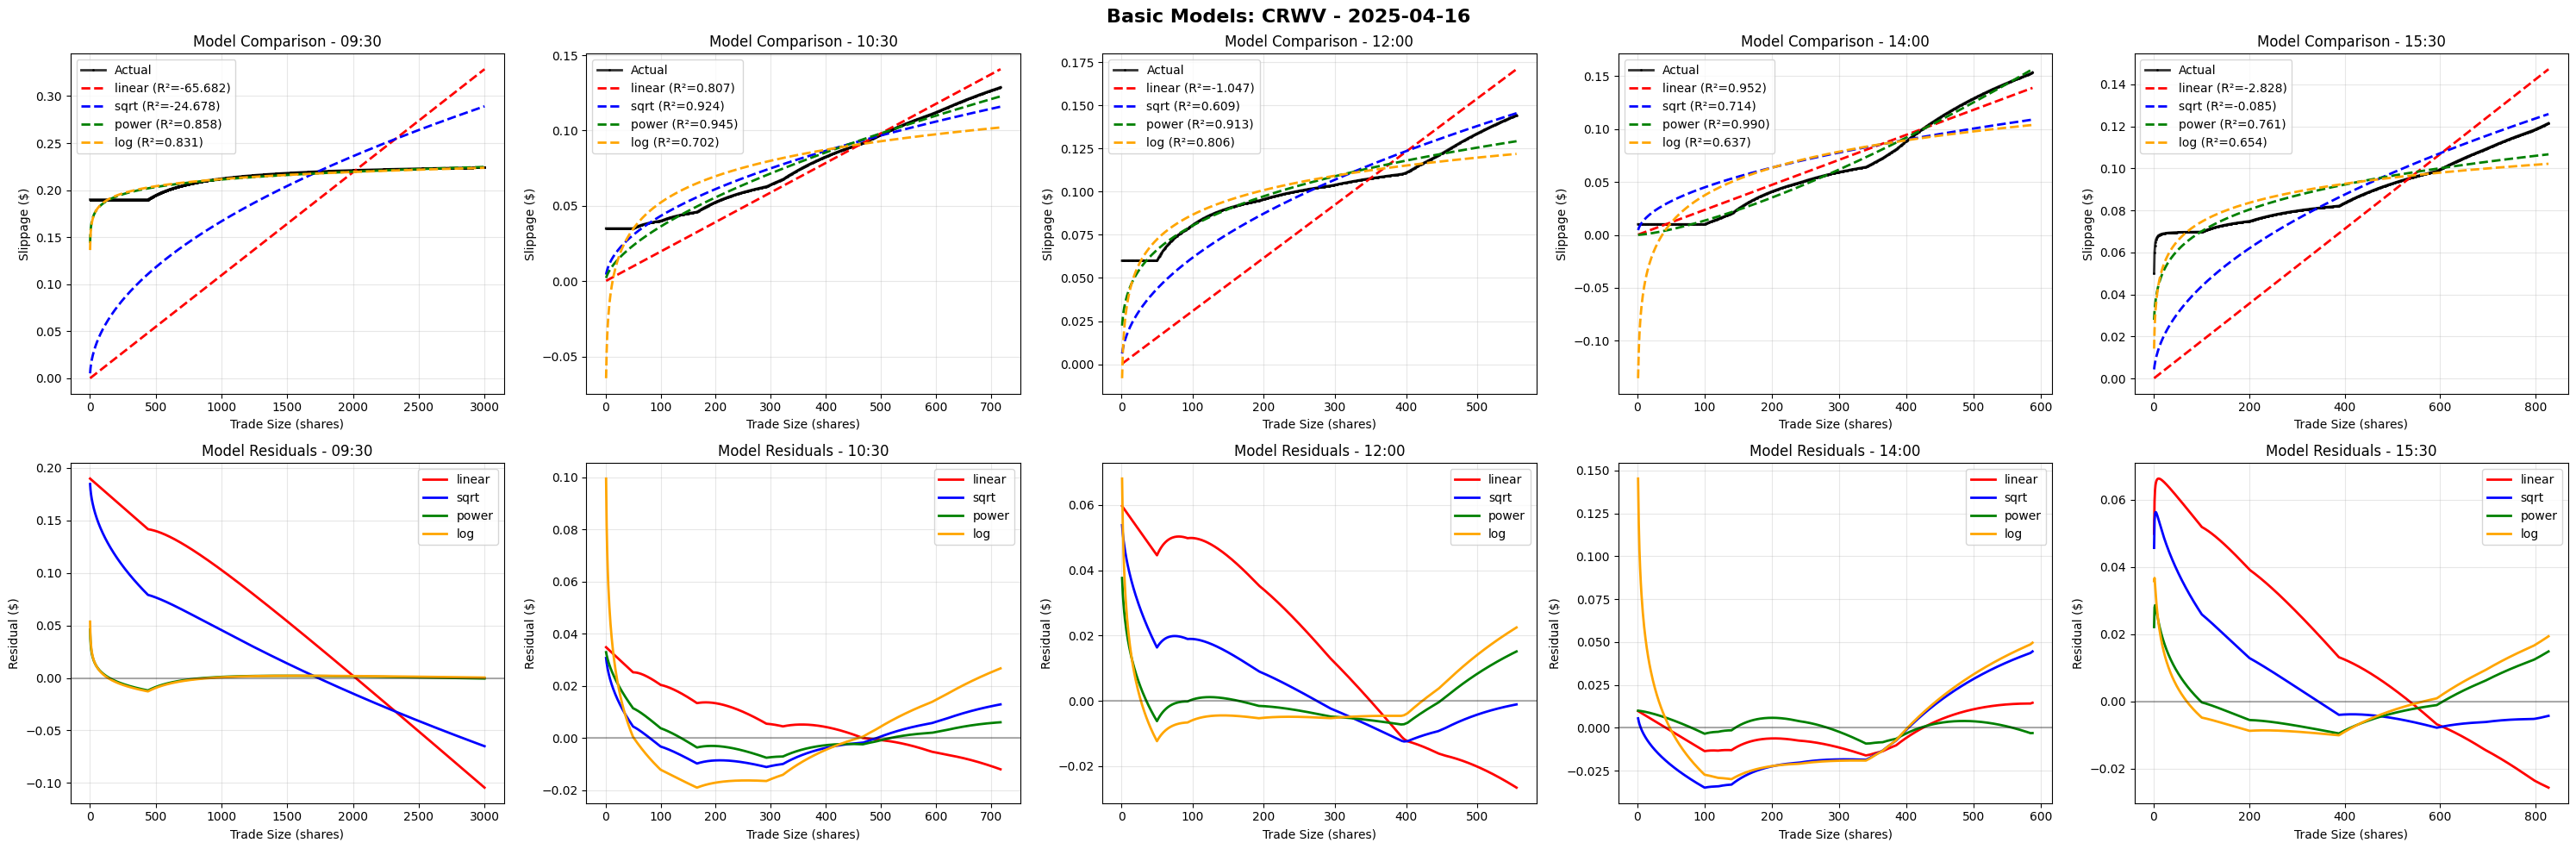

  Visualizing Advanced Industry Models...


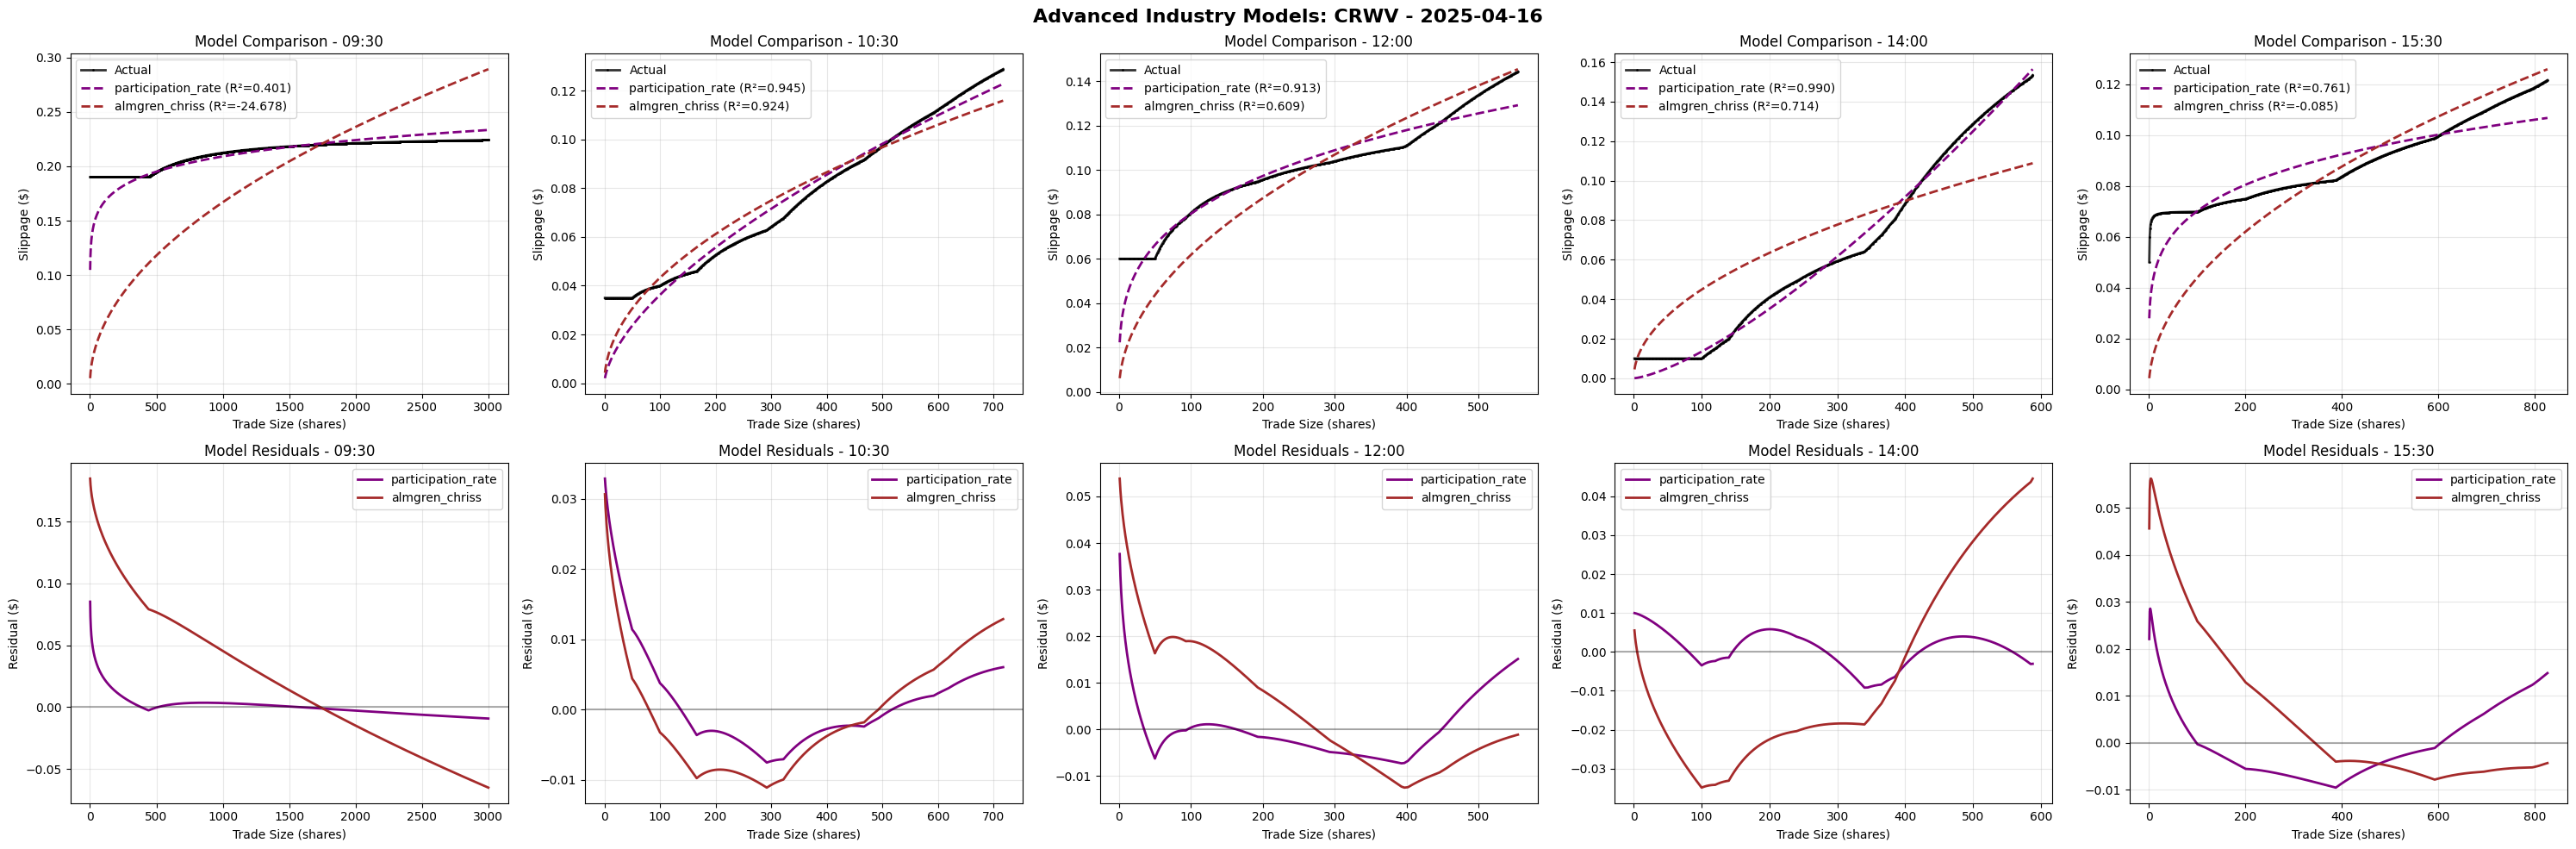

  Visualizing Additional Advanced Models...


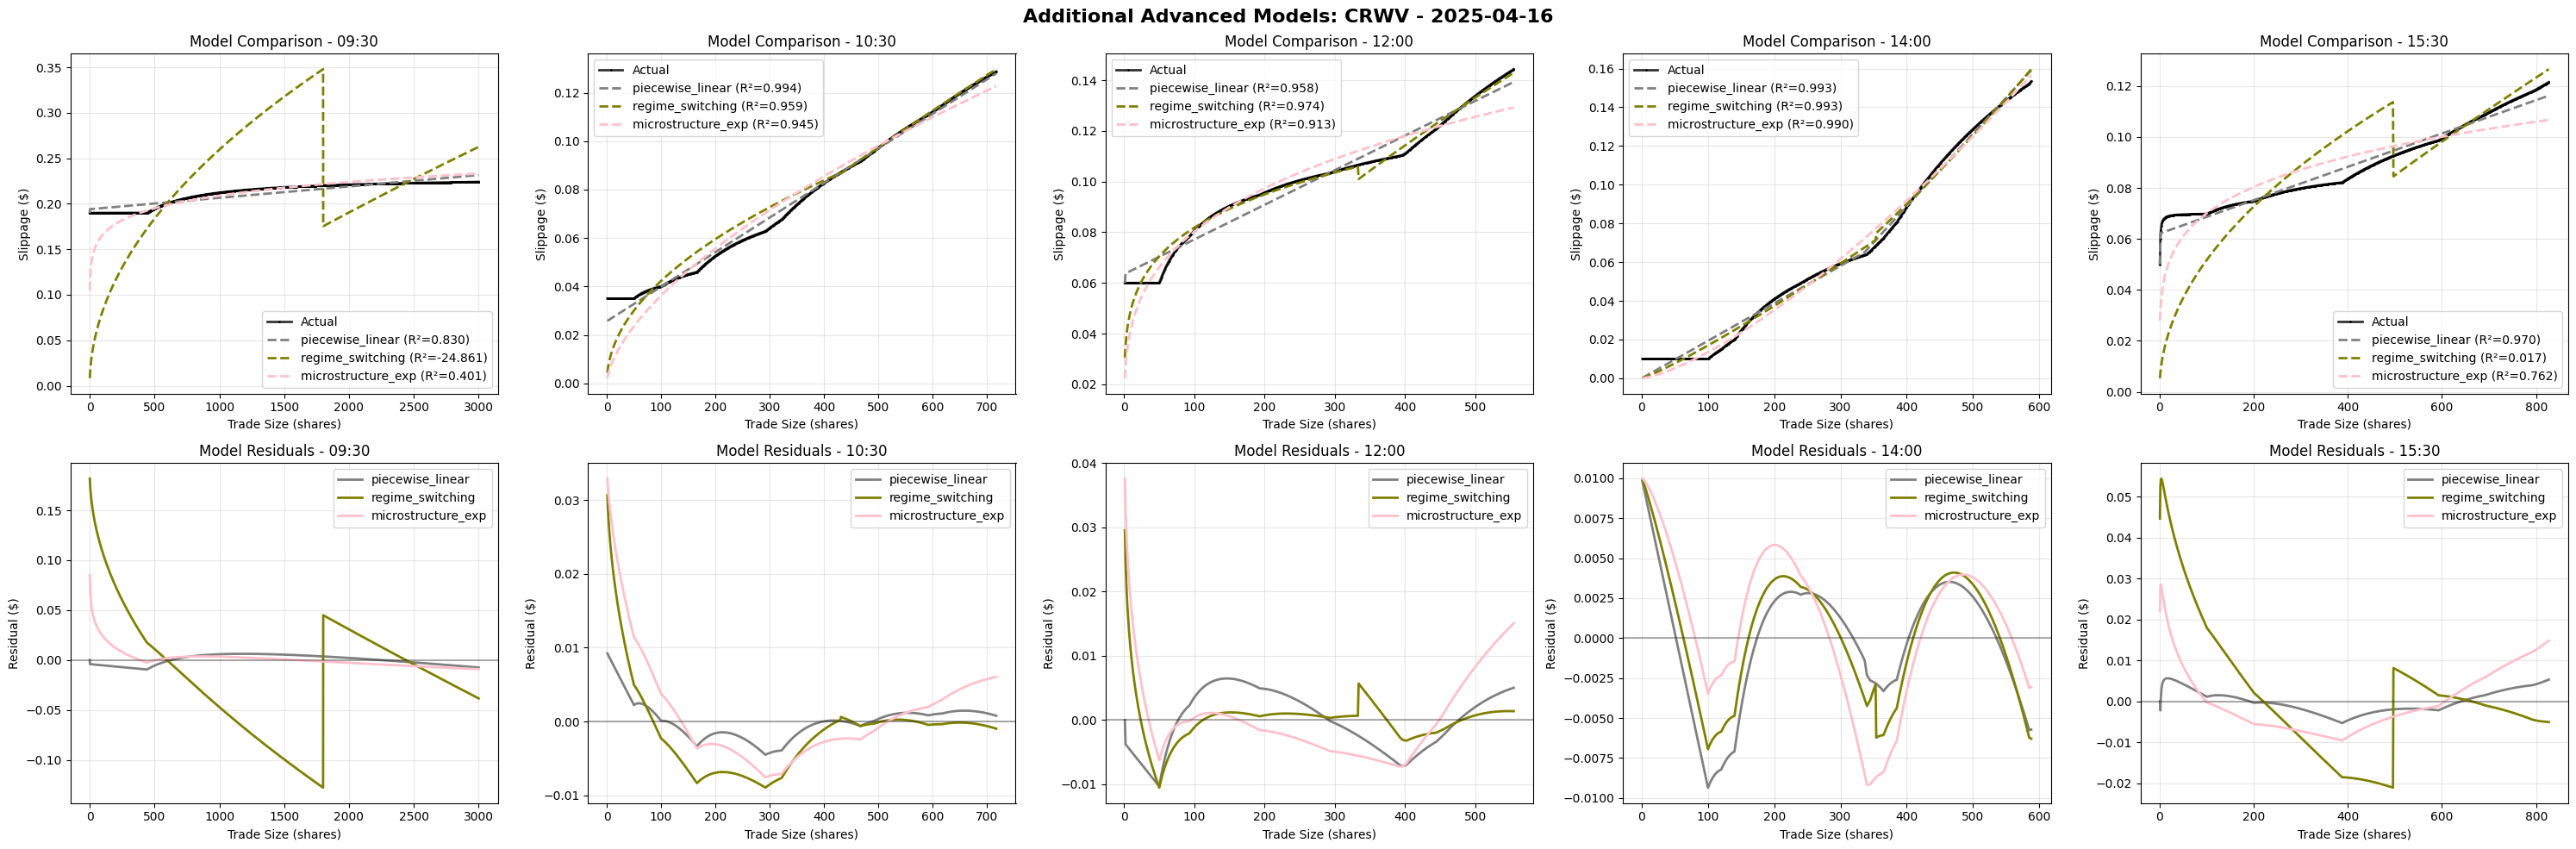


ANALYSIS SUMMARY

Best model per group (average R²):
  Additional Advanced Models: PIECEWISE_LINEAR (R² = 0.9489 ± 0.0682)
  Basic Models: POWER (R² = 0.8935 ± 0.0881)
  Additional Advanced Models: MICROSTRUCTURE_EXP (R² = 0.8023 ± 0.2400)
  Advanced Industry Models: PARTICIPATION_RATE (R² = 0.8021 ± 0.2400)

Top 5 models overall:
  1. PIECEWISE_LINEAR (Additional Advanced Models) - R² = 0.9489
  2. POWER (Basic Models) - R² = 0.8935
  3. MICROSTRUCTURE_EXP (Additional Advanced Models) - R² = 0.8023
  4. PARTICIPATION_RATE (Advanced Industry Models) - R² = 0.8021
  5. LOG (Basic Models) - R² = 0.7263

DATAFRAMES CREATED:
comparison_df: 45 rows - All model results
group_summary_df: 15 rows - Best per group per time
overall_ranking_df: 9 rows - Overall model ranking


In [12]:
# usage
final_results = analyze_and_visualize_slippage_by_groups("CRWV", "2025-04-16")

if final_results:
    # Access the DataFrames
    comparison_df = final_results['comparison_df']
    group_summary_df = final_results['group_summary_df'] 
    overall_ranking_df = final_results['overall_ranking_df']
    
    print("\n" + "="*80)
    print("DATAFRAMES CREATED:")
    print("="*80)
    print(f"comparison_df: {comparison_df.shape[0]} rows - All model results")
    print(f"group_summary_df: {group_summary_df.shape[0]} rows - Best per group per time")
    print(f"overall_ranking_df: {overall_ranking_df.shape[0]} rows - Overall model ranking")
